In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import json
from astropy.visualization import ZScaleInterval
from skimage.transform import probabilistic_hough_line as phl
import pandas as pd
from skimage.draw import line
from scipy.ndimage import binary_dilation
import skimage.morphology as morphology
from skimage.morphology import binary_erosion
from scipy.optimize import curve_fit, minimize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from scipy.ndimage import map_coordinates
from scipy.ndimage import median_filter
#import cv2

import sys
sys.path.append('../identify_sats')
from generate_astrometry import *
from postproc import *
ihu_table = pd.read_hdf('../identify_sats/IHU_TABLE.hdf')

zscale = ZScaleInterval()

In [5]:
#dydx = np.gradient(RR, CC, edge_order=2)
#d2y_dx2 = np.gradient(dydx, CC, edge_order=2)
#radii = np.abs( (1 + dydx ** 2)**1.5 / d2y_dx2 )

In [10]:
fex1 = '60_01'
fex2 = '60_03'
fspin1 = '69_43'
fspin2 = '69_05'
ffaint = '69_48'
fstraight ='69_59'
fgap1 = '69_39'
fcross1 = '69_41'
fgap2 = '69_45'
fcross2 = '69_48'
fgeo1 = '59_56'
fgeo2 = '69_57'
fmix = '69_58'

In [11]:
fspin2, ffaint, fcross1, fgeo2

('69_05', '69_48', '69_41', '69_57')

In [10]:
pd.DataFrame([0],columns=['numlines'])

,numlines
0,0


1
Length:  24.351591323771842
C0: 277, R0: 484.9629279796467
NGAPS:  0
277 300 293
[0, 12.175795661885921, 24.351591323771842, 1428.5425]
[5.20008269e-03 1.40236530e+01 2.19608256e+01 3.19499480e+03]
LBOUND:  0 RBOUND:  24.351591323771842


2
Length:  42.7551166528639
C0: 1560, R0: 1459.0686657337549
NGAPS:  0
1560 1602 1583
[0, 21.37755832643195, 42.7551166528639, 891.04224]
[1.36261037e-12 2.14124900e+01 3.67483382e+01 1.70193409e+03]
LBOUND:  0 RBOUND:  42.7551166528639


3
Length:  29.732137494637012
C0: 2, R0: 1532.928354434734
NGAPS:  0
2 30 27
[0, 14.866068747318506, 29.732137494637012, 932.21875]
[-5.28253400e-03  1.42709633e+01  2.40045557e+01  2.02100536e+03]
LBOUND:  0 RBOUND:  29.732137494637012


4
Length:  76.05918747922567
C0: 1702, R0: 1546.382369913746
NGAPS:  0
1702 1778 1730
[0, 38.029593739612835, 76.05918747922567, 158.52454]
[-3.13199716e-03  3.85887008e+01  7.25254119e+01  2.58003122e+02]
LBOUND:  0 RBOUND:  76.05918747922567


5
Length:  37.013511046643494
C0: 7

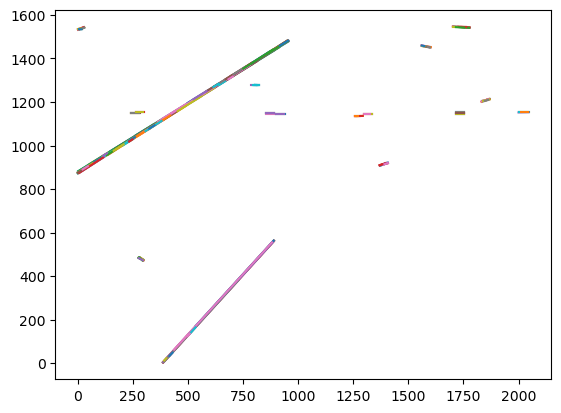

In [13]:
%%time
# MEGA THREAD:
fileroot = '1-430769_57'
file = '{}-sub.fits'.format(fileroot)
sub0 = read_fits_file(file)

with open('detection_{}.json'.format(fileroot), 'r') as f:
    data = json.load(f)
pixels = np.array(data['mask'])

mask = np.zeros((2048,2048))
mask[pixels[:,1],pixels[:,0]] += 1

rollingmedian = median_filter(sub0, size=21, mode='constant', cval=0)
sub = sub0 - rollingmedian

#mask_eroded = binary_erosion(mask,np.ones((3,3)))
lines = phl(mask, threshold=20, line_length=10, line_gap=10)
df0, slopes, bs = get_line_data(lines)

dindex, NUMLINES = collect_segments(sub, df0, PLOT=False)
df0['linenum'] = dindex

NCLOSE = 10
NHALF = 1
NSIG = 3
mask_MASTER = np.zeros((2048,2048))
mask_DEL = np.zeros((2048,2048))
RPOINTS = []
CPOINTS = []
COLUMNS = ['linenum','c1','c2','r1','r2','cpix','rpix']
FINALLIST = pd.DataFrame()
maxi = 2 #len(np.unique(df0.linenum.values))
i = 0
df = df0.copy()
while i < maxi:
    LINENUM = np.unique(df.linenum.values.astype(int))[i]
    print(LINENUM)
    RR, CC, LENGTH = total_line_coords(df, LINENUM=LINENUM, PLOT=False)
    print('Length: ', LENGTH)
    #plot_amplitude(RR, CC, sub);
    rr, cc, R0, C0, coefficients = fit_coords(RR, CC, LENGTH, sub, PLOT=False)
    GAPS, NGAPS = find_gaps(rr, cc, RR, CC, R0, C0, sub, GAP=2, w=50)
    dat, rollmean, rollstd = rolling_mean(rr, cc, R0, C0, sub)

    df, LBOUNDS, RBOUNDS, NEWLENGTH = find_bounds(rr, cc, RR, CC, R0, C0, df, 
                                                  LINENUM, LENGTH, dat, rollmean, rollstd, 
                                                  GAPS, NGAPS, sub, NSIG=4, PLOT=False)

    if NEWLENGTH > 200:
        rr_end = rr[(dat.dx.values>LBOUNDS[0])&(dat.dx.values<RBOUNDS[0])]
        cc_end = cc[(dat.dx.values>LBOUNDS[0])&(dat.dx.values<RBOUNDS[0])]
        #plt.figure()
        #plt.scatter(cc_end, rr_end)
        #plt.title(LINENUM)
        #plt.show()
        mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
                                                                  C0, sub, NSIG, NHALF, NCLOSE, PLOT=False)
    elif NEWLENGTH < 200:
        RR, CC, LENGTH = total_line_coords(df, LINENUM=LINENUM, PLOT=False)
        rr_end = RR # rr[(dat.dx.values>=0)&(dat.dx.values<=NEWLENGTH)]
        cc_end = CC # cc[(dat.dx.values>=0)&(dat.dx.values<=NEWLENGTH)]
        #plt.figure()
        #plt.scatter(CC, RR)#cc_end, rr_end)
        #plt.title(LINENUM)
        #plt.show()
        mask_new = np.zeros((2048,2048))
        mask_new[RR,CC] += 1
        mask_new = morphology.binary_closing(mask_new, morphology.disk(NCLOSE))
        
    data = {'linenum':LINENUM,'c1':cc_end.min(),'c2':cc_end.max(),'r1':rr_end[np.argmin(cc_end)],'r2':rr_end[np.argmax(cc_end)],
            'cpix':[cc_end],'rpix':[rr_end]}
    NEWLIST = pd.DataFrame(data)
    FINALLIST = pd.concat([FINALLIST, NEWLIST], ignore_index=True)
    lpoints = np.arange(0.,1.1,0.1)*LENGTH #LENGTH+10,10)
    mids = np.argmin(np.abs(dat.dx.values-lpoints.reshape(1,len(lpoints)).T),axis=1)
    CPOINTS.append(cc[mids])#[cc_end.min(),list(cc[mid]),cc_end.max()])
    RPOINTS.append(rr[mids])#[rr_end[np.argmin(cc_end)],list(rr[mid]),rr_end[np.argmax(cc_end)]])

    mask_MASTER += mask_new
    #mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
    #                                                          C0, sub, NSIG=3, NHALF=2, NCLOSE=10, PLOT=False)
    #mask_DEL += mask_new
    i += 1
    maxi = len(np.unique(df.linenum.values))
    print('\n')

FINALLIST = FINALLIST.drop(columns=['linenum'])
IOL = np.zeros(len(FINALLIST))
IOR = np.zeros(len(FINALLIST))
IOT = np.zeros(len(FINALLIST))
IOB = np.zeros(len(FINALLIST))
IOframe = np.zeros(len(FINALLIST))
IOframe[(FINALLIST.c1==1)|(FINALLIST.c2==2047)|(FINALLIST.r1==1)|(FINALLIST.r1==2047)|(FINALLIST.r2==1)|(FINALLIST.r2==2047)] = 1
IOL[(FINALLIST.c1==1)] = 1
IOR[(FINALLIST.c2==2047)] = 1
IOB[(FINALLIST.r1==1)|(FINALLIST.r2==1)] = 1
IOT[(FINALLIST.r1==2047)|(FINALLIST.r2==2047)] = 1
FINALLIST['IOframe'] = IOframe
FINALLIST['IOL'] = IOL
FINALLIST['IOR'] = IOR
FINALLIST['IOT'] = IOT
FINALLIST['IOB'] = IOB

In [14]:
ntimes = 10
#lnum = 8
npoints = len(CPOINTS[0])
print('number of points: ', npoints)

for lnum in range(len(CPOINTS)):
    RA, DEC = get_coords(file, np.array(CPOINTS[lnum]), np.array(RPOINTS[lnum]))
    RA_s, DEC_s, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                        sort=False, inframe=False, log=False)
    repeat = np.repeat([RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot],ntimes,axis=1)
    repeat[-1] += np.concatenate(np.repeat(np.linspace(0,exptime,ntimes)[np.newaxis, :],npoints,axis=0))/(24*3600)
    RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot = repeat
    lineids = np.arange(0,len(ra_h),1)
    trueids = np.repeat(np.arange(0,npoints,1),ntimes,axis=0)
    write_astrometry_file(fileroot, lineids, ra_h.astype(int), ra_m.astype(int), ra_s, dec_d.astype(int), dec_m.astype(int), dec_s, 
                          year, month, day_tot)
    #!sat_id test.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > MEGATESTER.txt



    import subprocess
    
    result = subprocess.run([
        'sat_id', 'test.ast',
        '-t', '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt',
        '-r', '0.5',
        '-m', '20',
        '-v'
    ], capture_output=True, text=True, check=True)
    
    # Or process the output in Python
    print(result.stdout)

results = result.stdout.split('\n')
check = False
names = []
offsets = []
pixelid = []
times = []
periods = []
incs = []
eccs = []
for i in range(len(results)):
    L=results[i]
    if L[:6] == '     L':
        times.append(float(L[23:31]))
        pixelid.append(int(L[6:12]))
        check = True
        continue
    if check == True:
        name = L[52:].split(':')[1].lstrip().strip('\n')
        names.append(name)
        periods.append(float(L.split('P=')[1].split('min')[0]))
        incs.append(float(L.split('i=')[1].split(':')[0]))
        eccs.append(float(L.split('e=')[1].split(';')[0]))
        check = False
    if 'offset' in L:
        offsets.append(float(L[-11:-5]))

periods = np.array(periods)
avals = (6.67*1e-11*5.972*1e24/(4*np.pi**2)*(periods*60)**2)**(1/3)
alts = (avals - 6371*1000)/1000

number of points:  11


Arg 0: 'sat_id'
Arg 1: 'test.ast'
Arg 2: '-t'
Arg 3: '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt'
Arg 4: '-r'
Arg 5: '0.5'
Arg 6: '-m'
Arg 7: '20'
Arg 8: '-v'
Station codes: 140697 bytes read
110 observations found
110 objects
110 objects after removing slow ones
Looking through TLE file '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt', 110 objs, radius 0.500000, max 20.000000 revs/day
     L000080  C2024 11 16.01629 23 36 20.44 +05 50 33.5                      304
     43651U = 2018-079A   e=0.01; P=1436.1 min; i=1.7: AEHF 4 (USA 288)
             no observed motion (single obs)  dist= 36555.2 km; offset= 0.4702 deg
             motion 15.1357"/sec at PA  88.2 (computed)

     L000081  C2024 11 16.01635 23 36 20.44 +05 50 33.5                      304
     43651U = 2018-079A   e=0.01; P=1436.1 min; i=1.7: AEHF 4 (USA 288)
             no observed motion (single obs)  dist= 36555.2 km; offset= 0.4759 deg
             motion 15.1356"/sec at PA  88.2 (computed)


In [31]:
results = result.stdout.split('\n')
check = False
names = []
offsets = []
pixelid = []
times = []
periods = []
incs = []
eccs = []
for i in range(len(results)):
    L=results[i]
    if L[:6] == '     L':
        times.append(float(L[23:31]))
        pixelid.append(int(L[6:12]))
        check = True
        continue
    if check == True:
        name = L[52:].split(':')[1].lstrip().strip('\n')
        names.append(name)
        periods.append(float(L.split('P=')[1].split('min')[0]))
        incs.append(float(L.split('i=')[1].split(':')[0]))
        eccs.append(float(L.split('e=')[1].split(';')[0]))
        check = False
    if 'offset' in L:
        offsets.append(float(L[-11:-5]))

periods = np.array(periods)
avals = (6.67*1e-11*5.972*1e24/(4*np.pi**2)*(periods*60)**2)**(1/3)
alts = (avals - 6371*1000)/1000

In [34]:
names

['AEHF 4 (USA 288)',
 'AEHF 4 (USA 288)',
 'AEHF 4 (USA 288)',
 'AEHF 4 (USA 288)',
 'AEHF 4 (USA 288)',
 'STARLINK-31402',
 'STARLINK-31402',
 'STARLINK-31402',
 'STARLINK-31402',
 'NOAA 16 DEB',
 'NOAA 16 DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB',
 'TITAN 3C TRANSTAGE DEB']

In [3]:
from scipy.ndimage import distance_transform_edt
L1 = np.zeros((2048,2048))
L1[dat.iloc[1].rpix, dat.iloc[1].cpix] += 1
dist_transform = distance_transform_edt(L1)
current_thickness = 2 * dist_transform.max()
print(current_thickness)

from skimage.morphology import skeletonize
skeleton = skeletonize(mask)
plt.imshow(skeleton,origin='lower')

lines = phl(skeleton, threshold=20, line_length=10, line_gap=10)
df0, slopes, bs = get_line_data(lines)
dindex, NUMLINES = collect_segments(df0, PLOT=False)
df0['linenum'] = dindex

NameError: name 'dat' is not defined

In [19]:
EDGE_THRESHOLD=5
T = (np.abs(Rmax-FINALLIST.r1)<=EDGE_THRESHOLD)|(np.abs(Rmax-FINALLIST.r2)<=EDGE_THRESHOLD)
B = (np.abs(Rmin-FINALLIST.r1)<=EDGE_THRESHOLD)|(np.abs(Rmin-FINALLIST.r2)<=EDGE_THRESHOLD)
R = np.abs(Cmax-FINALLIST.c2) <= EDGE_THRESHOLD
L = np.abs(Cmin-FINALLIST.c1) <= EDGE_THRESHOLD

In [34]:
HI = np.zeros(len(FINALLIST))
HI[T|B|L|R]=1
HI

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])

In [28]:
FINALLIST

,c1,c2,r1,r2,cpix,rpix,IOframe,IOL,IOR,IOT,IOB
0,277,300,482,474,"[277, 277, 277, 278, 278, 278, 279, 279, 279, ...","[482, 484, 485, 482, 484, 483, 481, 484, 483, ...",0.0,0.0,0.0,0.0,0.0
1,1560,1602,1459,1453,"[1560, 1560, 1561, 1561, 1561, 1561, 1562, 156...","[1459, 1460, 1459, 1459, 1458, 1460, 1458, 145...",0.0,0.0,0.0,0.0,0.0
2,1702,1778,1547,1543,"[1702, 1703, 1704, 1705, 1706, 1707, 1708, 170...","[1547, 1547, 1547, 1547, 1547, 1547, 1546, 154...",0.0,0.0,0.0,0.0,0.0
3,1,30,1532,1541,"[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, ...","[1532, 1533, 1532, 1533, 1535, 1532, 1535, 153...",1.0,1.0,0.0,0.0,0.0
4,788,825,1277,1277,"[788, 789, 789, 790, 790, 791, 791, 792, 792, ...","[1277, 1277, 1278, 1277, 1278, 1278, 1277, 127...",0.0,0.0,0.0,0.0,0.0
5,243,302,1150,1155,"[243, 243, 244, 244, 244, 244, 245, 245, 245, ...","[1150, 1149, 1151, 1150, 1149, 1148, 1149, 115...",0.0,0.0,0.0,0.0,0.0
6,1832,1869,1203,1213,"[1832, 1832, 1832, 1833, 1833, 1833, 1833, 183...","[1203, 1202, 1201, 1203, 1202, 1204, 1201, 120...",0.0,0.0,0.0,0.0,0.0
7,1370,1408,910,920,"[1370, 1370, 1371, 1371, 1371, 1372, 1372, 137...","[910, 909, 908, 910, 909, 908, 911, 910, 910, ...",0.0,0.0,0.0,0.0,0.0
8,1,957,876,1482,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[876, 876, 877, 878, 878, 879, 880, 880, 881, ...",1.0,1.0,0.0,0.0,0.0
9,386,893,2,566,"[386, 387, 388, 389, 390, 391, 392, 393, 394, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1...",0.0,0.0,0.0,0.0,0.0


In [12]:
for lnum in range(len(CPOINTS)):
    RA, DEC = get_coords(file, np.array(CPOINTS[lnum]), np.array(RPOINTS[lnum]))
    RA_s, DEC_s, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                        sort=False, inframe=False, log=False)
    repeat = np.repeat([RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot],ntimes,axis=1)
    repeat[-1] += np.concatenate(np.repeat(np.linspace(0,exptime,ntimes)[np.newaxis, :],npoints,axis=0))/(24*3600)
    RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot = repeat
    lineids = np.arange(0,len(ra_h),1)
    trueids = np.repeat(np.arange(0,npoints,1),ntimes,axis=0)
    write_astrometry_file('fileroot', lineids, ra_h.astype(int), ra_m.astype(int), ra_s, dec_d.astype(int), dec_m.astype(int), dec_s, 
                          year, month, day_tot)
    satidfile='fileroot.txt'
    !sat_id fileroot.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > fileroot.txt

In [19]:
try:
    rfile = '1-4307{}-red.fits'.format(fgeo2)
    red = read_fits_file(rfile)
except:
    print("file doesn't exist")

In [7]:
file = '1-4307{}-sub.fits'.format(fgeo2)
sub0 = read_fits_file(file)

with open('detection_1-4307{}.json'.format(fgeo2), 'r') as f:
    data = json.load(f)
pixels = np.array(data['mask'])

mask = np.zeros((2048,2048))
mask[pixels[:,1],pixels[:,0]] += 1


In [8]:
rollingmedian = median_filter(sub0, size=21, mode='constant', cval=0)
sub = sub0 - rollingmedian


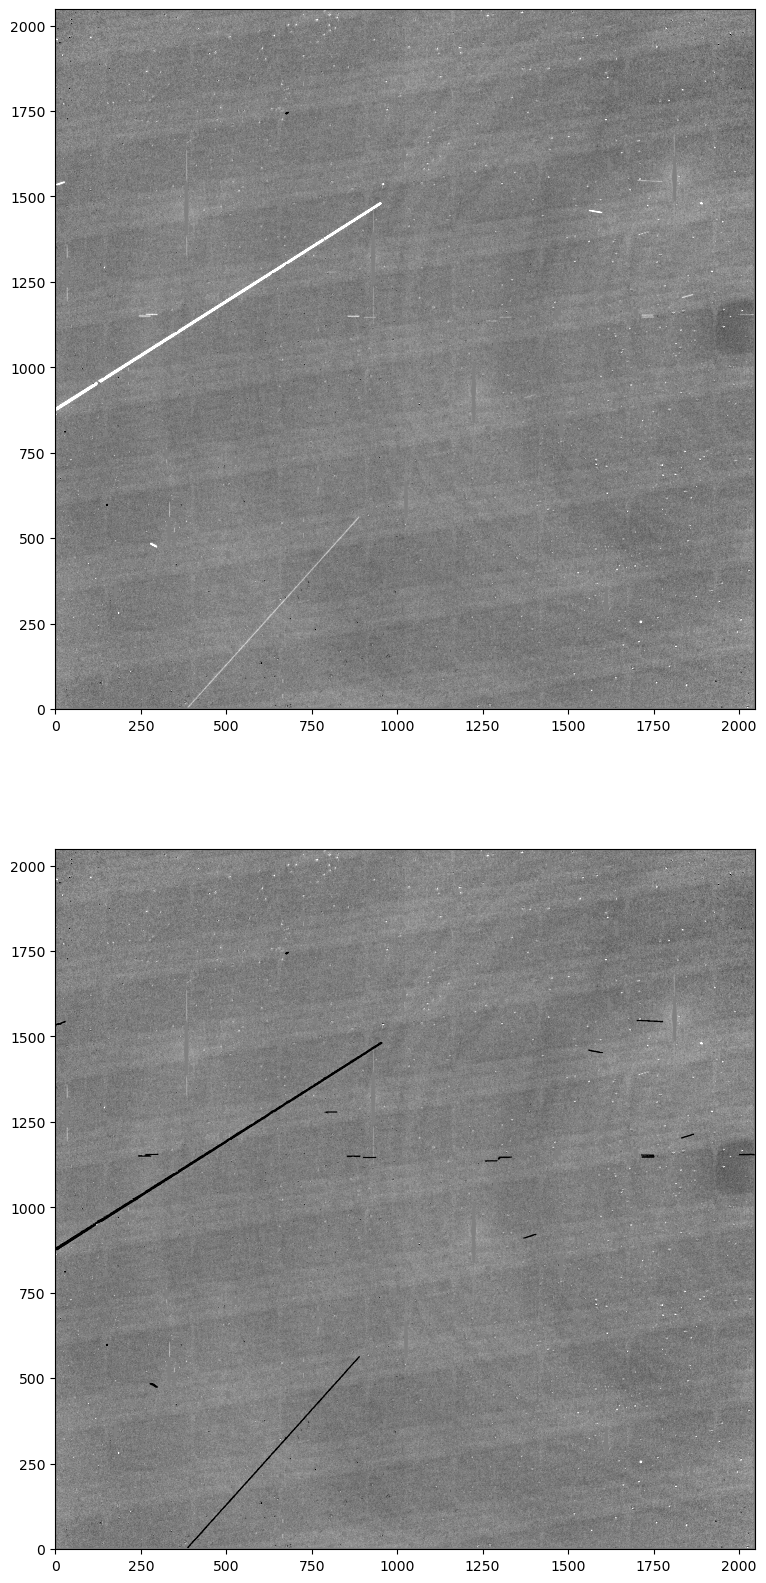

In [20]:
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize=(20,20))

min_value, max_value = zscale.get_limits(sub0)
ax[0].imshow(sub0, vmin=min_value, vmax=max_value, origin='lower', cmap='gray')

PLOT=False
if PLOT:
    ax[0].axvline(leftC,lw=0.5,c='r')
    ax[0].axvline(rightC,lw=0.5,c='r')
    ax[0].axvline(hatmid-hatwidth/2,lw=0.5,c='b')
    ax[0].axvline(hatmid+hatwidth/2,lw=0.5,c='b')
    #ax[0].set_xlim(1400,1600)
    #ax[0].set_ylim(1000,1250)
    #ax[0].scatter(cc,rr,s=1)

subm = sub0.copy()
subm[pixels[:,1],pixels[:,0]] = -700
ax[1].imshow(subm, vmin=min_value, vmax=max_value, origin='lower', cmap='gray')
#ax[1].scatter(pixels[:,0],pixels[:,1],s=10/2048,color='r')

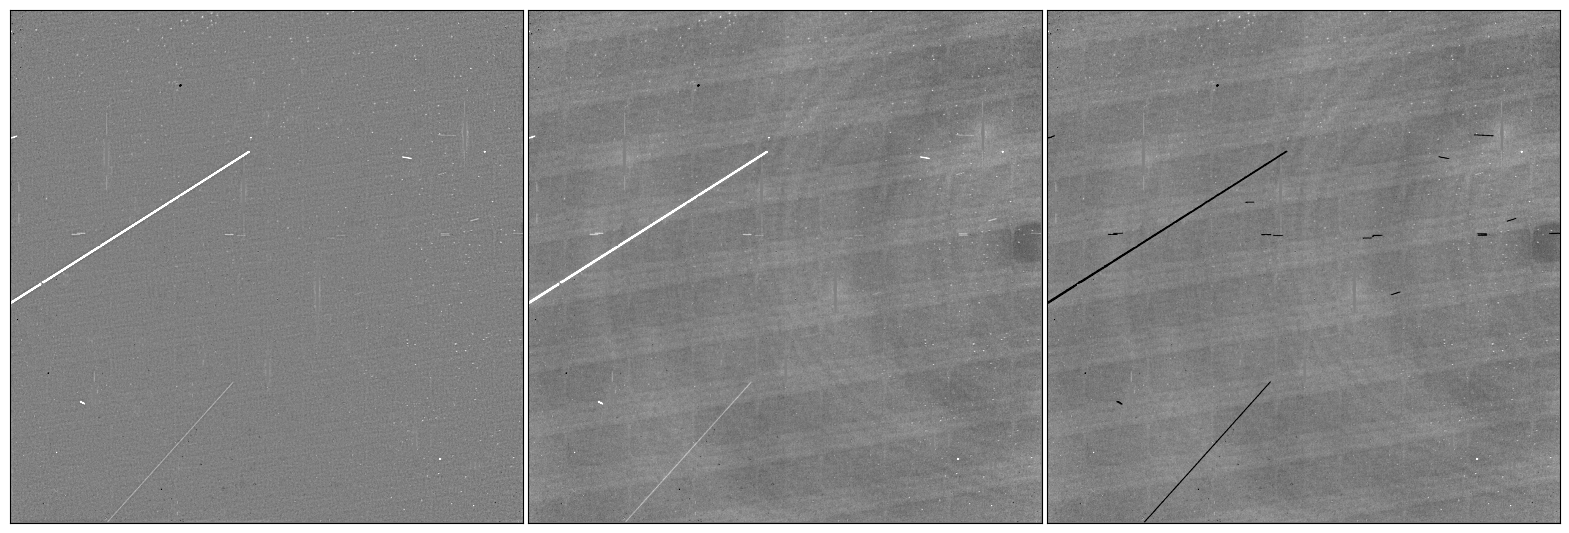

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(20,30))

min_value, max_value = zscale.get_limits(sub)#red
ax[0].imshow(sub, vmin=min_value, vmax=max_value, origin='lower', cmap='gray')#red


min_value, max_value = zscale.get_limits(sub)
ax[1].imshow(sub0, vmin=min_value, vmax=max_value, origin='lower', cmap='gray')

subm = sub0.copy()
subm[pixels[:,1],pixels[:,0]] = -700
ax[2].imshow(subm, vmin=min_value, vmax=max_value, origin='lower', cmap='gray')

plt.subplots_adjust(wspace=0.01)
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#ax[1].scatter(pixels[:,0],pixels[:,1],s=10/2048,color='r')
#plt.savefig('detection_example_5.png', bbox_inches='tight')

In [17]:
Csplit = np.where(np.diff(np.where(np.sum(sub,axis=0)==0))[0]>1)[0]
Cmin = np.where(np.sum(sub,axis=0)==0)[0][Csplit][0]
Cmax = np.where(np.sum(sub,axis=0)==0)[0][Csplit+1][0]
Rsplit = np.where(np.diff(np.where(np.sum(sub,axis=1)==0))[0]>1)[0]
Rmin = np.where(np.sum(sub,axis=1)==0)[0][Rsplit][0]
Rmax = np.where(np.sum(sub,axis=1)==0)[0][Rsplit+1][0]
Cmin, Cmax, Rmin, Rmax

(3, 2044, 3, 2044)

sub vs subsub model - photometry production, find the width of the trail so we can put the pixels in. no need to fill in gaps? how to integrate it into the general pipeline? when do we need to invole the model, gpu in LCO etc., 

We have N lines identified by the hough transform. We can create an D=NxN matrix and for each pair of lines, we put a 1 in the [i,j] spot and the [j,i] spot.

loop 0 goes through lines 1-N, fills in D[0,1:N] and D[1:N,0]

loop 1 fills in D[1,0 and 2:N] and D[0 and 2:N,1]

loop 2 fills in D[2,0 and 1 and 3:N] and D[0 and 1 and 3:N,2]

so actually we just need to loop through i in 1:N, and j in i+1:N.

Next, we need to find all the subsets that have at least one element in common with each other. In other words, if lines 0 and 1 go together, and lines 1 and 2 go together, we will say that line 0 and 2 also go together. We can loop through the lines and go about it like this. We find the set of lines {I_1} that are associated with line i. Then for set {I_1}, we go through and find all the lines {I_2} associated with each of these lines and create a mega set {I_1,I_2}. And then you do the same thing with {I_2}. You continue this process until there are no new line ids being added to the set.


process a good chunk of data: start getting a sense of stats, how well the post-processing works, any cuts or filters you can put in, etc. How much data do we need? A month that then gets analyzed in each year? Try to do things keeping in mind you might return to this 6 months later (extra documentation), well-labeled directories (e.g. month and year as prefix)

176

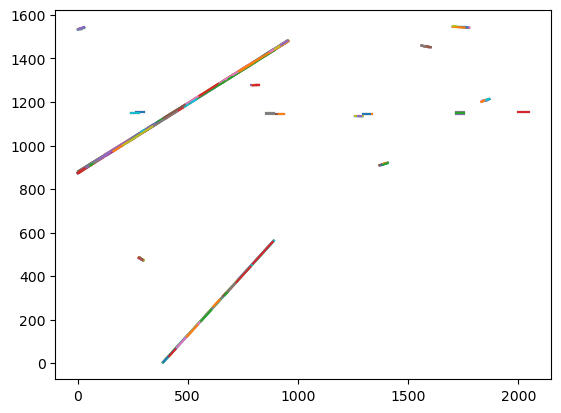

In [9]:
%matplotlib inline
mask_eroded = binary_erosion(mask,np.ones((3,3)))
lines = phl(mask, threshold=20, line_length=10, line_gap=10)
df0, slopes, bs = get_line_data(lines)
len(df0)

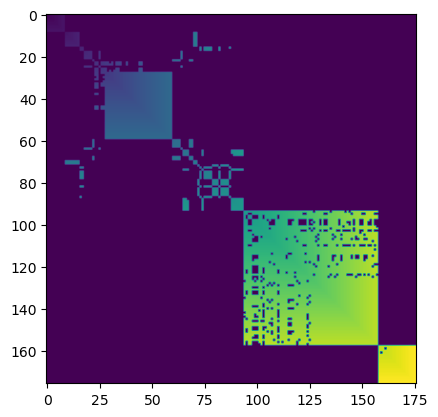

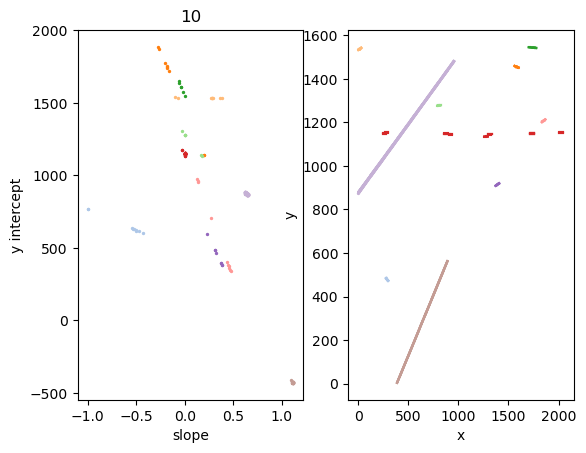

In [10]:
dindex, NUMLINES = collect_segments(df0, PLOT=False)
df0['linenum'] = dindex

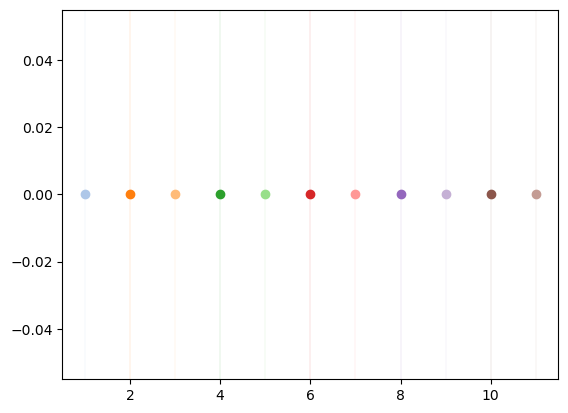

In [11]:
%matplotlib inline

for i in range(1,NUMLINES+2):
    plt.axvline(i,zorder=0,lw=0.1,color=plt.colormaps['tab20'](i))
    plt.scatter(i,0,color=plt.colormaps['tab20'](i));

In [11]:
%matplotlib inline
NCLOSE = 10
NHALF = 1
NSIG = 3
mask_MASTER = np.zeros((2048,2048))
mask_DEL = np.zeros((2048,2048))
RPOINTS = []
CPOINTS = []
COLUMNS = ['linenum','c1','c2','r1','r2','cpix','rpix']
FINALLIST = pd.DataFrame()
maxi = 2 #len(np.unique(df0.linenum.values))
i = 0
df = df0.copy()
while i < maxi:
    LINENUM = np.unique(df.linenum.values.astype(int))[i]
    print(LINENUM)
    RR, CC, LENGTH = total_line_coords(df, LINENUM=LINENUM, PLOT=False)
    print('Length: ', LENGTH)
    #plot_amplitude(RR, CC, sub);
    rr, cc, R0, C0, coefficients = fit_coords(RR, CC, LENGTH, sub, PLOT=False)
    GAPS, NGAPS = find_gaps(rr, cc, RR, CC, R0, C0, w=50)
    dat, rollmean, rollstd = rolling_mean(rr, cc, R0, C0, sub)

    df, LBOUNDS, RBOUNDS, NEWLENGTH = find_bounds(df, LINENUM, LENGTH, dat, rollmean, rollstd, 
                                       GAPS, NGAPS, sub, NSIG=4, PLOT=False)

    if NEWLENGTH > 200:
        rr_end = rr[(dat.dx.values>LBOUNDS[0])&(dat.dx.values<RBOUNDS[0])]
        cc_end = cc[(dat.dx.values>LBOUNDS[0])&(dat.dx.values<RBOUNDS[0])]
        #plt.figure()
        #plt.scatter(cc_end, rr_end)
        #plt.title(LINENUM)
        #plt.show()
        mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
                                                                  C0, sub, NSIG, NHALF, NCLOSE, PLOT=False)
    elif NEWLENGTH < 200:
        RR, CC, LENGTH = total_line_coords(df, LINENUM=LINENUM, PLOT=False)
        rr_end = RR # rr[(dat.dx.values>=0)&(dat.dx.values<=NEWLENGTH)]
        cc_end = CC # cc[(dat.dx.values>=0)&(dat.dx.values<=NEWLENGTH)]
        #plt.figure()
        #plt.scatter(CC, RR)#cc_end, rr_end)
        #plt.title(LINENUM)
        #plt.show()
        mask_new = np.zeros((2048,2048))
        mask_new[RR,CC] += 1
        mask_new = morphology.binary_closing(mask_new, morphology.disk(NCLOSE))
        
    data = {'linenum':LINENUM,'c1':cc_end.min(),'c2':cc_end.max(),'r1':rr_end[np.argmin(cc_end)],'r2':rr_end[np.argmax(cc_end)],
            'cpix':[cc_end],'rpix':[rr_end]}
    NEWLIST = pd.DataFrame(data)
    FINALLIST = pd.concat([FINALLIST, NEWLIST], ignore_index=True)
    lpoints = np.arange(0.,1.1,0.1)*LENGTH #LENGTH+10,10)
    mids = np.argmin(np.abs(dat.dx.values-lpoints.reshape(1,len(lpoints)).T),axis=1)
    CPOINTS.append(cc[mids])#[cc_end.min(),list(cc[mid]),cc_end.max()])
    RPOINTS.append(rr[mids])#[rr_end[np.argmin(cc_end)],list(rr[mid]),rr_end[np.argmax(cc_end)]])

    mask_MASTER += mask_new
    #mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
    #                                                          C0, sub, NSIG=3, NHALF=2, NCLOSE=10, PLOT=False)
    #mask_DEL += mask_new
    i += 1
    maxi = len(np.unique(df.linenum.values))
    print('\n')

1
Length:  24.698178070456937
C0: 277, R0: 484.6139453551914
NGAPS:  0
277 300 298
[0, 12.349089035228468, 24.698178070456937, 1378.2203]
[8.07912531e-13 1.31915256e+01 2.06069303e+01 3.19804821e+03]
LBOUND:  0 RBOUND:  24.698178070456937


2
Length:  42.7551166528639
C0: 1560, R0: 1458.857700195736
NGAPS:  0
1560 1602 1577
[0, 21.37755832643195, 42.7551166528639, 792.7143]
[-1.86254554e-03  2.15697362e+01  3.72241374e+01  1.75000189e+03]
LBOUND:  0 RBOUND:  42.7551166528639


3
Length:  31.016124838541646
C0: 1, R0: 1532.7675870079872
NGAPS:  0
1 30 27
[0, 15.508062419270823, 31.016124838541646, 991.2718]
[9.84004712e-13 1.49719099e+01 2.49382773e+01 2.05981421e+03]
LBOUND:  0 RBOUND:  31.016124838541646


4
Length:  1079.0203890566665
C0: 792, R0: 1282.1661602461718
NGAPS:  1
0 825 697
LBOUND:  -105.68055917422171 RBOUND:  -94.23187067681447
1832 2047 1855
LBOUND:  1055.1240766279636 RBOUND:  1070.0617759205252
newline
length of arrays:  1 1


5
Length:  76.10519036176179
C0: 1702, R

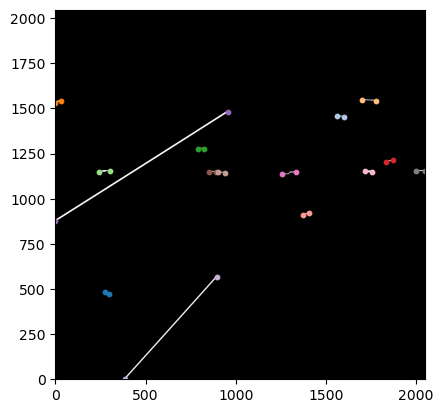

In [24]:
plt.imshow(mask_MASTER,origin='lower',cmap='Greys_r');
for i in range(len(FINALLIST)):
    plt.scatter(FINALLIST.iloc[i][['c1','c2']],FINALLIST.iloc[i][['r1','r2']],s=10,color=plt.colormaps['tab20'](i))

In [14]:
FINALLIST = FINALLIST.drop(columns=['linenum'])
IOL = np.zeros(len(FINALLIST))
IOR = np.zeros(len(FINALLIST))
IOT = np.zeros(len(FINALLIST))
IOB = np.zeros(len(FINALLIST))
IOframe = np.zeros(len(FINALLIST))
IOframe[(FINALLIST.c1==1)|(FINALLIST.c2==2047)|(FINALLIST.r1==1)|(FINALLIST.r1==2047)|(FINALLIST.r2==1)|(FINALLIST.r2==2047)] = 1
IOL[(FINALLIST.c1==1)] = 1
IOR[(FINALLIST.c2==2047)] = 1
IOB[(FINALLIST.r1==1)|(FINALLIST.r2==1)] = 1
IOT[(FINALLIST.r1==2047)|(FINALLIST.r2==2047)] = 1
FINALLIST['IOframe'] = IOframe
FINALLIST['IOL'] = IOL
FINALLIST['IOR'] = IOR
FINALLIST['IOT'] = IOT
FINALLIST['IOB'] = IOB
FINALLIST

KeyError: "['linenum'] not found in axis"

Sometimes one line will be associated with multiple objects. To pin down which is the correct one, we need to slide over the line and make sure the object is a consistent match. Basically I think is we have N points from the line. The exposure time is T. For each N, we match it up with a fine (? coarse?) grid of times. The times that match up best with each point should all be in linear order. So basically you need to repeat each point say like 10 times.

In [75]:
ntimes = 10
lnum = 8
npoints = len(CPOINTS[lnum])

RA, DEC = get_coords(file, np.array(CPOINTS[lnum]), np.array(RPOINTS[lnum]))
RA_s, DEC_s, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                    sort=False, inframe=False, log=False)
repeat = np.repeat([RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot],ntimes,axis=1)
repeat[-1] += np.concatenate(np.repeat(np.linspace(0,exptime,ntimes)[np.newaxis, :],npoints,axis=0))/(24*3600)
RA, DEC, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, day_tot = repeat
lineids = np.arange(0,len(ra_h),1)
trueids = np.repeat(np.arange(0,npoints,1),ntimes,axis=0)
write_astrometry_file('test', lineids, ra_h.astype(int), ra_m.astype(int), ra_s, dec_d.astype(int), dec_m.astype(int), dec_s, 
                      year, month, day_tot)

!sat_id test.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > test.txt

In [76]:
!sat_id test.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > test.txt

In [119]:
results = open('test.txt',"r")
file_size = os.path.getsize('test.txt')
i = 0
check = False
names = []
offsets = []
pixelid = []
times = []
periods = []
incs = []
eccs = []
while results:
    L=results.readline()
    if L[:6] == '     L':
        #print(int(line[6:12]))
        #print(line[23:31])
        times.append(float(L[23:31]))
        pixelid.append(int(L[6:12]))
        check = True
        continue
    if check == True:
        #print(L[52:], L[52:].split(':')[1].lstrip().strip('\n'))
        name = L[52:].split(':')[1].lstrip().strip('\n')
        names.append(name)
        periods.append(float(L.split('P=')[1].split('min')[0]))
        incs.append(float(L.split('i=')[1].split(':')[0]))
        eccs.append(float(L.split('e=')[1].split(';')[0]))
        check = False
    if 'offset' in L:
        offsets.append(float(L[-11:-5]))
    if i == file_size:
        break
    i += 1

periods = np.array(periods)
avals = (6.67*1e-11*5.972*1e24/(4*np.pi**2)*(periods*60)**2)**(1/3)
alts = (avals - 6371*1000)/1000

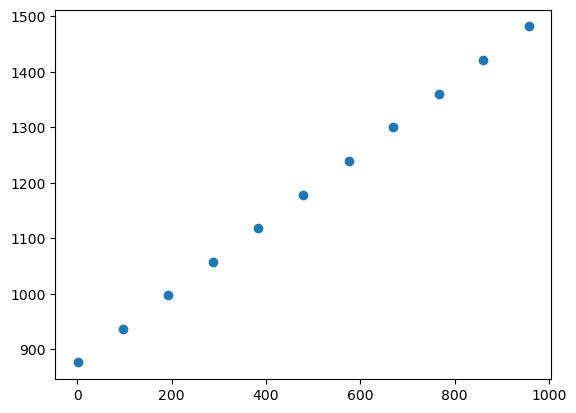

In [97]:
plt.scatter(CPOINTS[lnum], RPOINTS[lnum])

In [120]:
df = pd.DataFrame(np.array([names, alts, incs, eccs, offsets,pixelid,times]).T,columns=['name','alt','inc','ecc','offset','id','t'])
df['offset'] = df['offset'].astype(float)
df['id'] = df['id'].astype(int)
df['t'] = df['t'].astype(float)
df['pixnum'] = trueids[pixelid]
df = df.sort_values('pixnum')
df

,name,alt,inc,ecc,offset,id,t,pixnum
5,STARLINK-31402,343.95825865114574,43.0,0.0,0.2833,18,16.01675,1
13,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4622,12,16.01641,1
14,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4596,13,16.01646,1
15,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4575,14,16.01652,1
12,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4663,11,16.01635,1
11,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4714,10,16.01629,1
17,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4564,16,16.01664,1
16,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4564,15,16.01658,1
19,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4592,18,16.01675,1
18,TITAN 3C TRANSTAGE DEB,35293.67452657792,1.1,0.01,0.4575,17,16.01670,1


In [129]:
seg = df.loc[df.name=='STARLINK-31402']
ra,dec = RA[seg.id],DEC[seg.id]
ddeg = np.sqrt((ra.max()-ra.min())**2+(dec.max()-dec.min())**2)
ddeg/45

0.12366006965083019

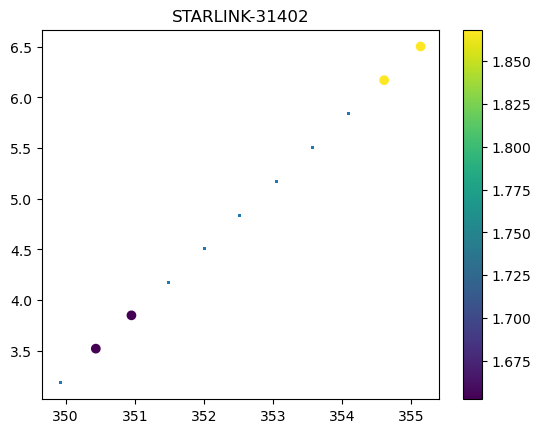

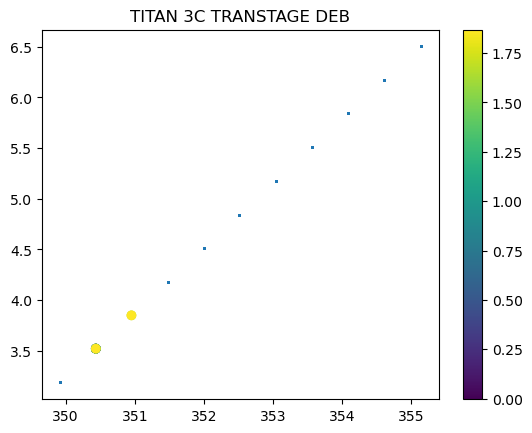

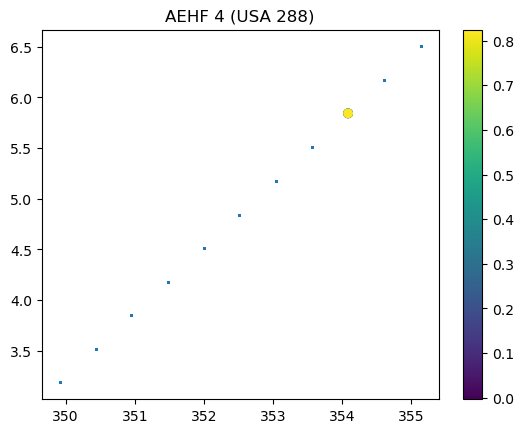

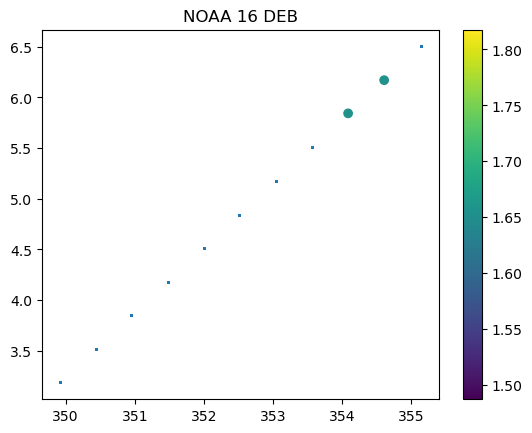

In [124]:
for i in df.name.unique():
    seg = df.loc[df.name==i]
    plt.figure()
    plt.scatter(RA, DEC,s=1)
    plt.scatter(RA[seg.id],DEC[seg.id],c=3600*(seg.t.values-day_tot.min()))
    plt.title(i)
    plt.colorbar()


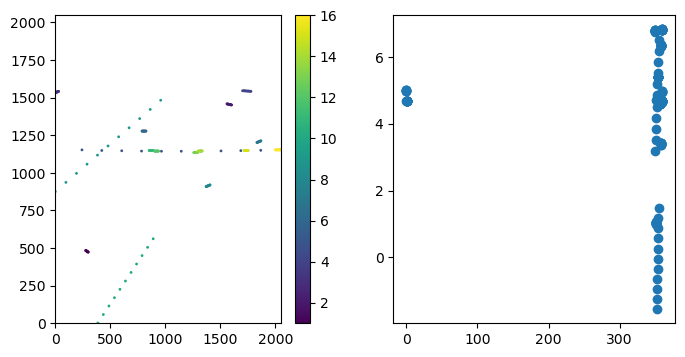

RA: 0h 0m 3.90s
DEC: 4d 58m 40.01s
RA: 0h 0m 9.14s
DEC: 4d 59m 18.53s
RA: 0h 0m 14.38s
DEC: 4d 59m 37.45s
RA: 0h 0m 19.61s
DEC: 4d 59m 56.38s
RA: 0h 0m 23.54s
DEC: 5d 0m 15.46s
RA: 0h 0m 25.56s
DEC: 4d 40m 0.50s
RA: 0h 0m 28.78s
DEC: 5d 0m 34.38s
RA: 0h 3m 19.13s
DEC: 4d 40m 36.78s
RA: 0h 3m 25.65s
DEC: 4d 40m 35.88s
RA: 0h 3m 30.87s
DEC: 4d 40m 35.16s
RA: 0h 3m 37.39s
DEC: 4d 40m 34.26s
RA: 0h 3m 43.90s
DEC: 4d 40m 33.35s
RA: 0h 3m 49.12s
DEC: 4d 40m 32.62s
RA: 0h 3m 55.64s
DEC: 4d 40m 31.71s
RA: 0h 4m 2.16s
DEC: 4d 40m 30.79s
RA: 0h 4m 8.67s
DEC: 4d 40m 29.87s
RA: 0h 4m 13.89s
DEC: 4d 40m 29.13s
RA: 0h 4m 20.42s
DEC: 4d 40m 47.77s
RA: 0h 4m 20.42s
DEC: 4d 40m 47.77s
RA: 23h 19m 35.03s
DEC: 6d 45m 32.30s
RA: 23h 19m 38.95s
DEC: 6d 45m 52.36s
RA: 23h 19m 39.75s
DEC: 3d 11m 14.02s
RA: 23h 19m 42.87s
DEC: 6d 46m 12.42s
RA: 23h 19m 46.80s
DEC: 6d 46m 32.48s
RA: 23h 19m 50.72s
DEC: 6d 46m 52.54s
RA: 23h 19m 54.64s
DEC: 6d 47m 12.60s
RA: 23h 19m 58.56s
DEC: 6d 47m 32.65s
RA: 23h 20m 2.48s
D

In [51]:
RA, DEC = get_coords(file, np.concatenate(CPOINTS), np.concatenate(RPOINTS))
fig, ax = plt.subplots(1,2, figsize=(8,4))
lineids = np.arange(0,len(RA),1)
trueids = np.repeat(np.arange(1,len(CPOINTS)+1,1),len(mids))
im=ax[0].scatter(CPOINTS, RPOINTS,s=1,c=trueids)
plt.colorbar(im, ax=ax[0])
ax[0].set_xlim(0,2048)
ax[0].set_ylim(0,2048)
plt.scatter(RA,DEC)
plt.show()
RA_s, DEC_s, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                    sort=True, inframe=True, log=True)
write_astrometry_file('all_lines', lineids, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
!sat_id all_lines.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.1 -m 20 -v #> all_lines_results.txt
RA_s_r, DEC_s_r, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=True, 
                                                                                    sort=True, inframe=True, log=False)
write_astrometry_file('all_lines', lineids, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
!sat_id all_lines.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.1 -m 20 -v# > all_lines_results_reverse.txt


In [121]:
results = open('all_lines_results.txt',"r")
file_size = os.path.getsize('all_lines_results.txt')
i = 0
check = False
names = []
offsets = []
pixelid = []
while results:
    line=results.readline()
    if line[:6] == '     L':
        #print(int(line[6:12]))
        pixelid.append(int(line[6:12]))
        check = True
        continue
    if check == True:
        #print(line[56:])
        name = line[56:-1]
        names.append(name)
        check = False
    if 'offset' in line:
        offsets.append(float(line[-11:-5]))
    if i == file_size:
        break
    i += 1

In [122]:
results = open('all_lines_results_reverse.txt',"r")
file_size = os.path.getsize('all_lines_results_reverse.txt')
i = 0
check = False
names_r = []
offsets_r = []
pixelid_r = []
while results:
    line=results.readline()
    if line[:6] == '     L':
        pixelid_r.append(int(line[6:12]))
        check = True
        continue
    if check == True:
        #print(line[56:])
        name = line[56:-1]
        names_r.append(name)
        check = False
    if 'offset' in line:
        offsets_r.append(float(line[-11:-5]))
    if i == file_size:
        break
    i += 1

In [123]:
df = pd.DataFrame(np.array([names, offsets,pixelid,np.zeros(len(names))]).T,columns=['name','offset','id','t'])
df = pd.concat([df, pd.DataFrame(np.array([names_r, offsets_r,pixelid_r,np.ones(len(names_r))]).T,columns=['name','offset','id','t'])])
df.groupby('name').min()

,offset,id,t
name,,,
ALAXY 17,0.0587,108,0.0
ALAXY 36,0.0068,1,0.0
ES 2,0.0088,53,0.0
IANE 3 R/B,0.0055,10,0.0
IANE 5 R/B,0.0034,176,0.0
IASAT 3,0.0091,12,0.0
IMAWARI 7,0.0019,25,0.0
IMIQ 4,0.0048,131,0.0
IRIUS FM-5,0.0031,60,0.0


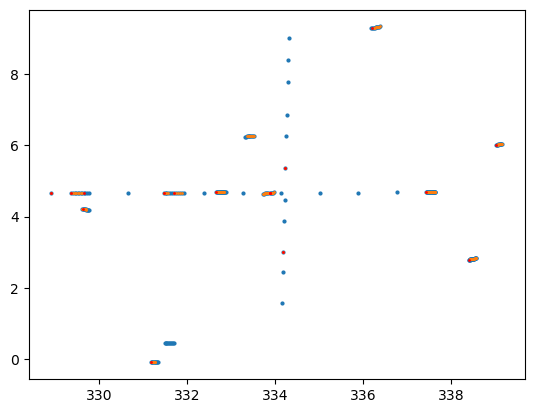

In [128]:
plt.scatter(RA_s, DEC_s,s=4)
plt.scatter(RA_s[pixelid],DEC_s[pixelid],s=1)
plt.scatter(RA_s[df.groupby('name').min().id.astype(int)],DEC_s[df.groupby('name').min().id.astype(int)],s=1,c='r')

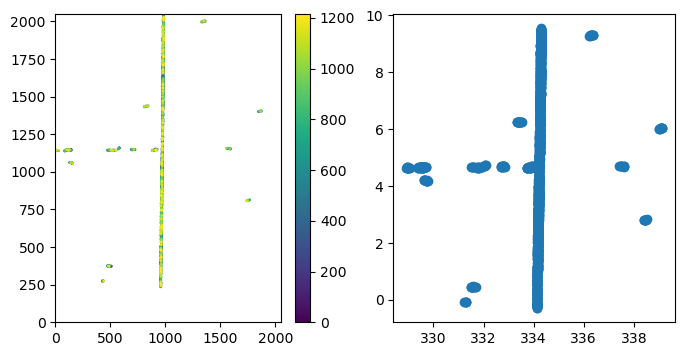

In [139]:
RA, DEC = get_coords(file, pixels[:,0][::10], pixels[:,1][::10])
fig, ax = plt.subplots(1,2, figsize=(8,4))
lineids = np.arange(0,len(RA),1)
im=ax[0].scatter(pixels[:,0][::10], pixels[:,1][::10],s=1,c=lineids)
plt.colorbar(im, ax=ax[0])
ax[0].set_xlim(0,2048)
ax[0].set_ylim(0,2048)
plt.scatter(RA,DEC)
plt.show()
RA_p_s, DEC_p_s, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                    sort=True, inframe=False, log=False)
write_astrometry_file('all_pixels', lineids, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
!sat_id all_pixels.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > all_pixels_result.txt
_, _, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=True, 
                                                                                    sort=True, inframe=False, log=False)
write_astrometry_file('all_pixels', lineids, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
!sat_id all_pixels.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt' -r 0.5 -m 20 -v > all_pixels_result_reverse.txt


In [187]:
results = open('all_pixels_result.txt',"r")
file_size = os.path.getsize('all_pixels_result.txt')
i = 0
check = False
names = []
offsets = []
pixelid = []
while results:
    line=results.readline()
    if line[:6] == '     L':
        #print(line)
        pixelid.append(int(line[6:12]))
        check = True
        continue
    if check == True:
        #print(line.split(':')[-1])
        name = line.split(':')[-1]
        names.append(name.lstrip()[:-1])
        check = False
    if 'offset' in line:
        offsets.append(float(line[-11:-5]))
    if i == file_size:
        break
    i += 1

results = open('all_pixels_result_reverse.txt',"r")
file_size = os.path.getsize('all_pixels_result_reverse.txt')
i = 0
check = False
names_r = []
offsets_r = []
pixelid_r = []
while results:
    line=results.readline()
    if line[:6] == '     L':
        #print(line)
        pixelid_r.append(int(line[6:12]))
        check = True
        continue
    if check == True:
        #print(line[56:])
        name = line.split(':')[-1]
        names_r.append(name.lstrip()[:-1])
        check = False
    if 'offset' in line:
        offsets_r.append(float(line[-11:-5]))
    if i == file_size:
        break
    i += 1

In [188]:
df = pd.DataFrame(np.array([names, offsets,pixelid,np.zeros(len(names))]).T,columns=['name','offset','id','t'])
df = pd.concat([df, pd.DataFrame(np.array([names_r, offsets_r,pixelid_r,np.ones(len(names_r))]).T,columns=['name','offset','id','t'])])
df.groupby('name').min()

,offset,id,t
name,,,
ARIANE 3 R/B,0.0026,13,0.0
ARIANE 5 R/B,0.004,120,0.0
COSMOS 894,0.0355,1001,1.0
GALAXY 17,0.0143,303,0.0
GALAXY 36,0.0019,0,0.0
GOES 19,0.0133,0,0.0
HIMAWARI 7,0.0046,63,0.0
IUS R/B(2),0.0067,1195,0.0
NIMIQ 4,0.0127,1186,0.0


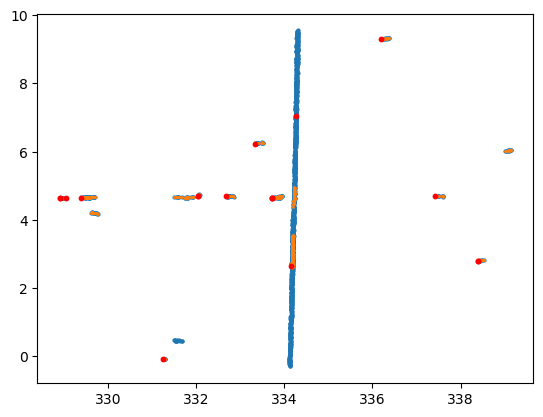

In [143]:
plt.scatter(RA_p_s, DEC_p_s,s=4)
plt.scatter(RA_p_s[pixelid],DEC_p_s[pixelid],s=1)
plt.scatter(RA_p_s[df.groupby('name').min().id.astype(int)],DEC_p_s[df.groupby('name').min().id.astype(int)],s=10,c='r')

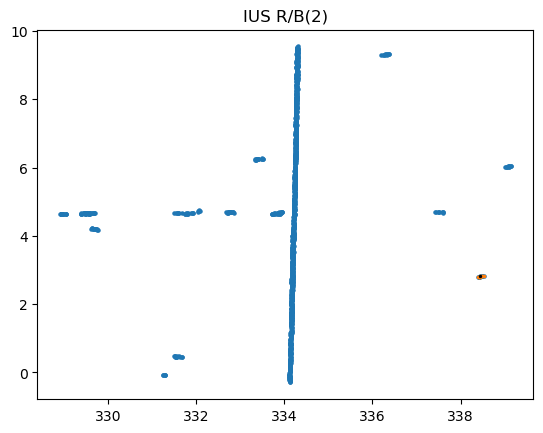

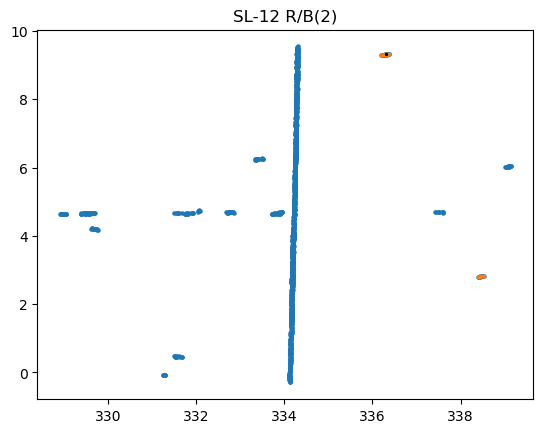

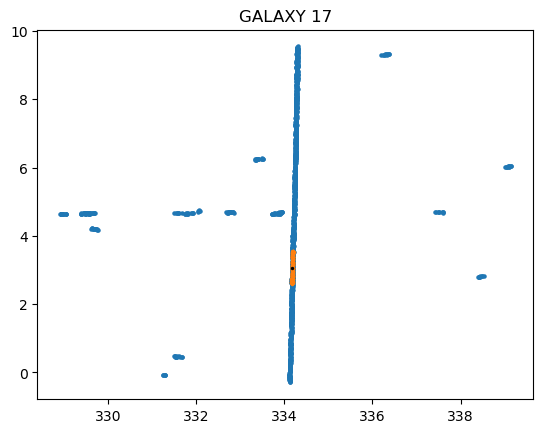

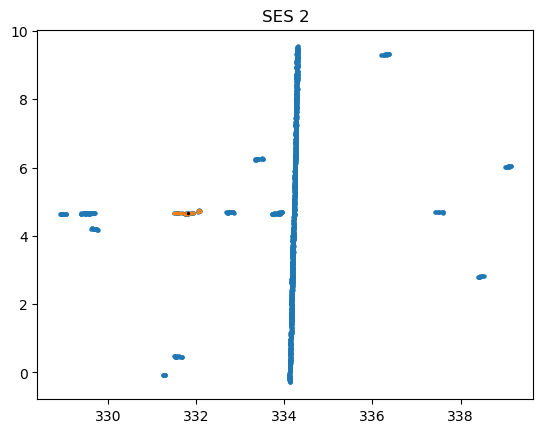

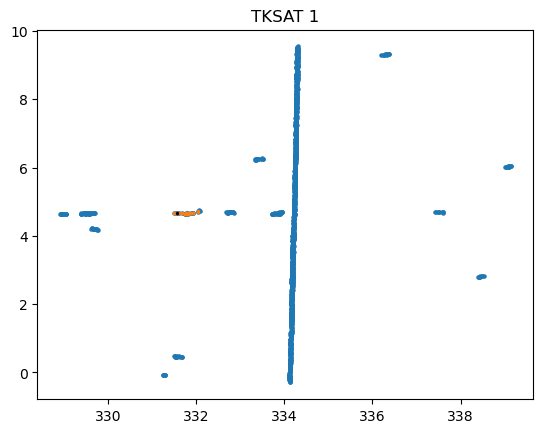

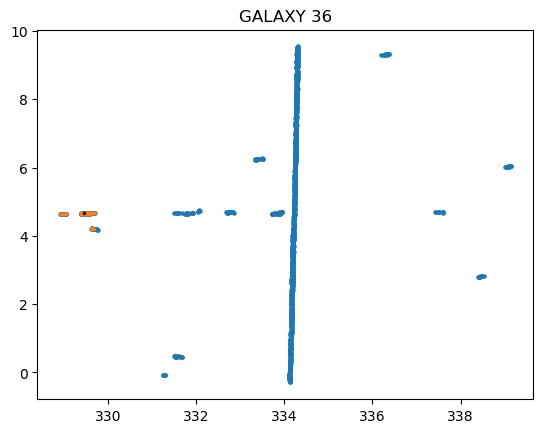

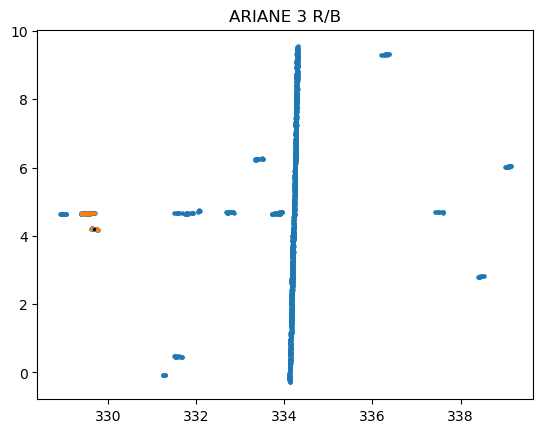

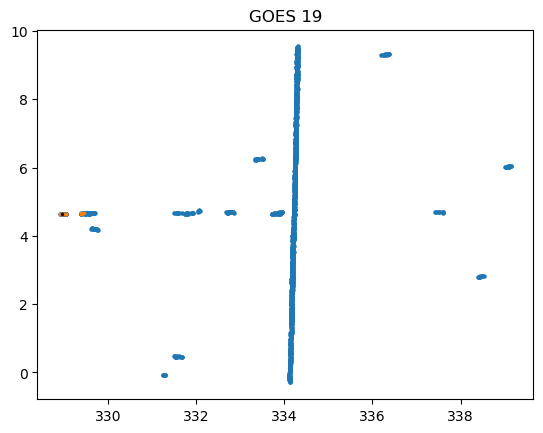

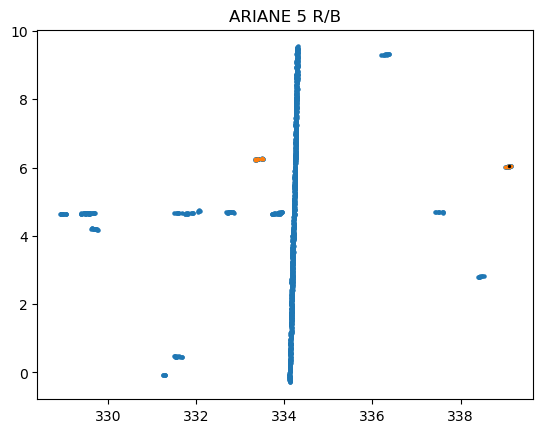

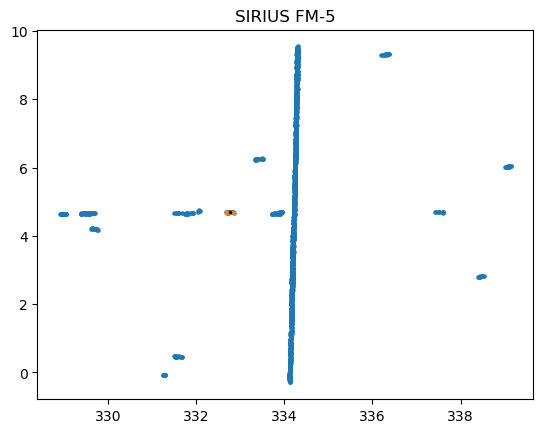

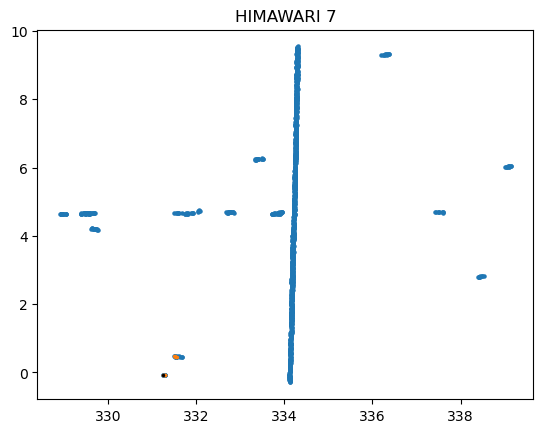

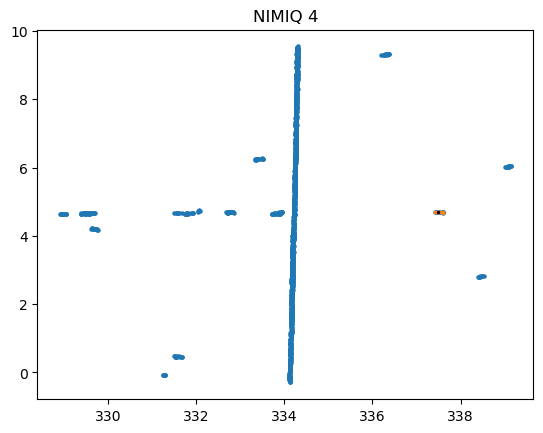

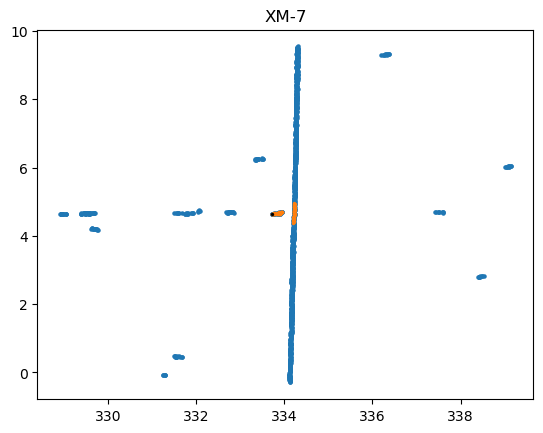

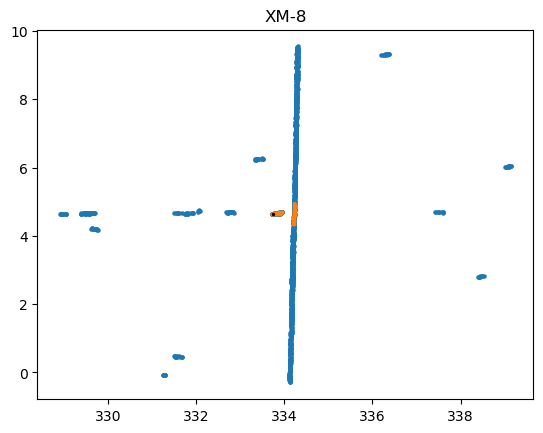

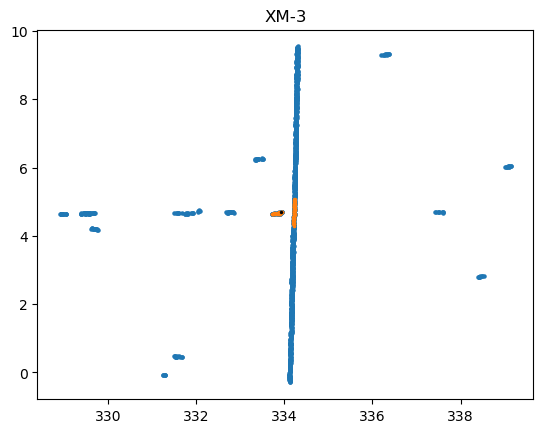

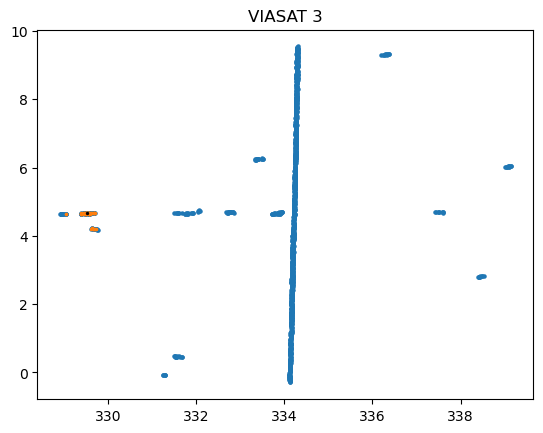

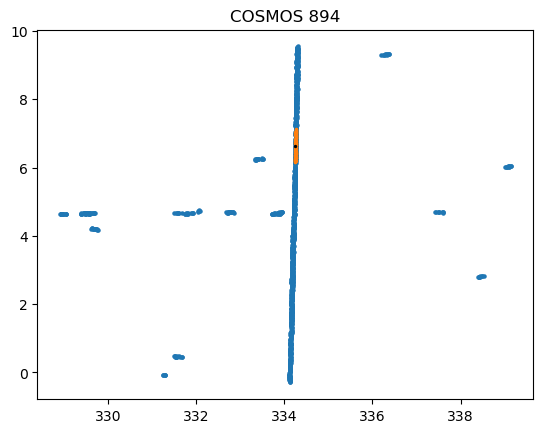

In [189]:
for n in df.name.unique():
    d = df.loc[df.name==n]
    min = d.loc[d.offset==d.offset.min()].id
    plt.figure()
    plt.scatter(RA_p_s, DEC_p_s,s=5)
    plt.scatter(RA_p_s[d.id.astype(int)],DEC_p_s[d.id.astype(int)],s=2)
    plt.scatter(RA_p_s[int(min)],DEC_p_s[int(min)],s=2,c='k')
    plt.title(n)

In [190]:
file

'1-430769_59-sub.fits'


 [130 133 136 139 142 145 148 151 153 156 159] [1064 1064 1063 1062 1061 1061 1060 1059 1059 1058 1057]
4.183249069098865 4.220984723362045 329.6130817369001 329.77093013679206


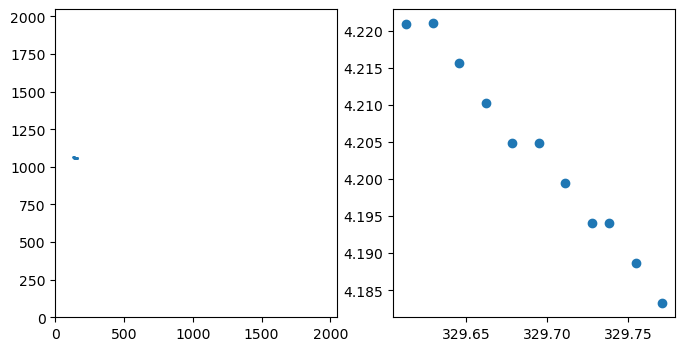

TypeError: write_astrometry_file() missing 1 required positional argument: 'day_tot'

In [53]:
for i in range(5):
    RA, DEC = get_coords(file, (CPOINTS[i]), (RPOINTS[i]))
    print('\n', CPOINTS[i], RPOINTS[i])
    print(DEC.min(), DEC.max(), RA.min(), RA.max())
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].scatter(CPOINTS[i], RPOINTS[i],s=1)
    ax[0].set_xlim(0,2048)
    ax[0].set_ylim(0,2048)
    plt.scatter(RA,DEC)
    plt.show()
    ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=False, 
                                                                                        sort=True, inframe=False, log=False)
    write_astrometry_file('single_line', ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
    !sat_id single_line.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt'
    ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot = astfile_info(RA, DEC, file, reverse=True, 
                                                                                        sort=True, inframe=False, log=False)
    write_astrometry_file('single_line_reverse', ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, exptime, year, month, day_tot)
    !sat_id single_line_reverse.ast -t '/data/CAT/TLE/satchecker_TLE_files/2024-11-15/ALL_TLE.txt'


array([ 2.41201835e+04, -2.85465481e-03,  6.93593386e-01])

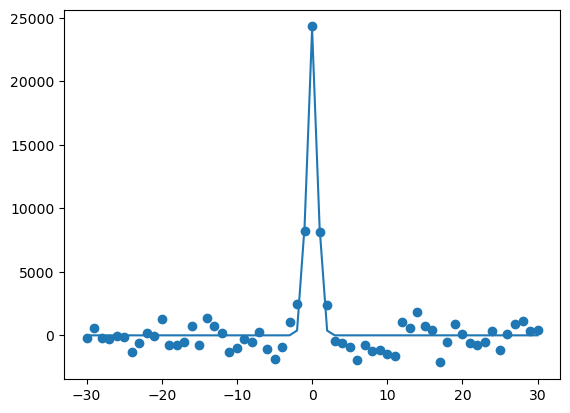

In [77]:
def fit_width(dat, lbound, rbound, rr, cc, R0, C0, sub, NSIG=3, NHALF=3, NCLOSE=10, PLOT=False):
    mask_fit = np.zeros((2048,2048))
    mask_fit[rr[(dat.dx.values>lbound)&(dat.dx.values<rbound)],
             cc[(dat.dx.values>lbound)&(dat.dx.values<rbound)]] = 1

    D, H = perpendicular_line_profile(sub, (cc[finder(cc,C0)], rr[finder(cc,C0)]), 
                                      (cc[finder(cc,C0+30)], rr[finder(cc,C0+30)]), 
                                      10, num_perp_points=None)
    
    #gauss(x, a, x0, sigma, offset) or gauss_with_linear(x, a, x0, sigma, b, c)
    p0 = [100,0,0.5]
    popt, _ = curve_fit(gauss, D, H, p0)
    amp, x0, sigma = popt
    sigma = np.abs(sigma)
    
    halfwidth = min(max(np.round(NSIG*sigma+0.5,0).astype(int),1),4)
    print('x0: {}, sigma: {}, halfwidth: {}'.format(x0,sigma,halfwidth))
    
    #width = np.sqrt(8*np.log(2)) * sigma + 1.
    #print(width/2)
        
    Hfit = gauss(D, *popt)
    
    if PLOT:
        plt.figure()
        plt.scatter(D,H)
        plt.plot(D,Hfit,c='r',lw=1)
        plt.axvline(NSIG*sigma+0.5)
        plt.axvline(-NSIG*sigma-0.5)
        plt.show()

    print('binary closing')
    mask_new = morphology.binary_closing(morphology.binary_dilation(mask_fit.astype(np.uint8), 
                                                                    morphology.disk(radius=NHALF*halfwidth)), 
                                         morphology.disk(NCLOSE))
    print('getting rr cc new')
    rr_new, cc_new = np.where(mask_new>0)[0], np.where(mask_new>0)[1]
    
    return mask_fit, mask_new, rr_new, cc_new, halfwidth


%matplotlib inline
D, H = perpendicular_line_profile(sub, (cc[finder(cc,C0)], rr[finder(cc,C0)]), 
                                  (cc[finder(cc,C0+30)], rr[finder(cc,C0+30)]), 
                                  30, num_perp_points=None)
plt.scatter(D,H)

p0 = [1000,0,0.5]
popt, _ = curve_fit(gauss, D, H, p0)
amp, x0, sigma = popt

plt.plot(D,gauss(D,*popt))
halfwidth = max(np.round(3*sigma+0.5,0).astype(int),1)
popt

FWHM + 0.5 pix (take fraction as determiner of mask/no mask for additional pixel).. stellar profile stored in header files and then blur it?? confusion

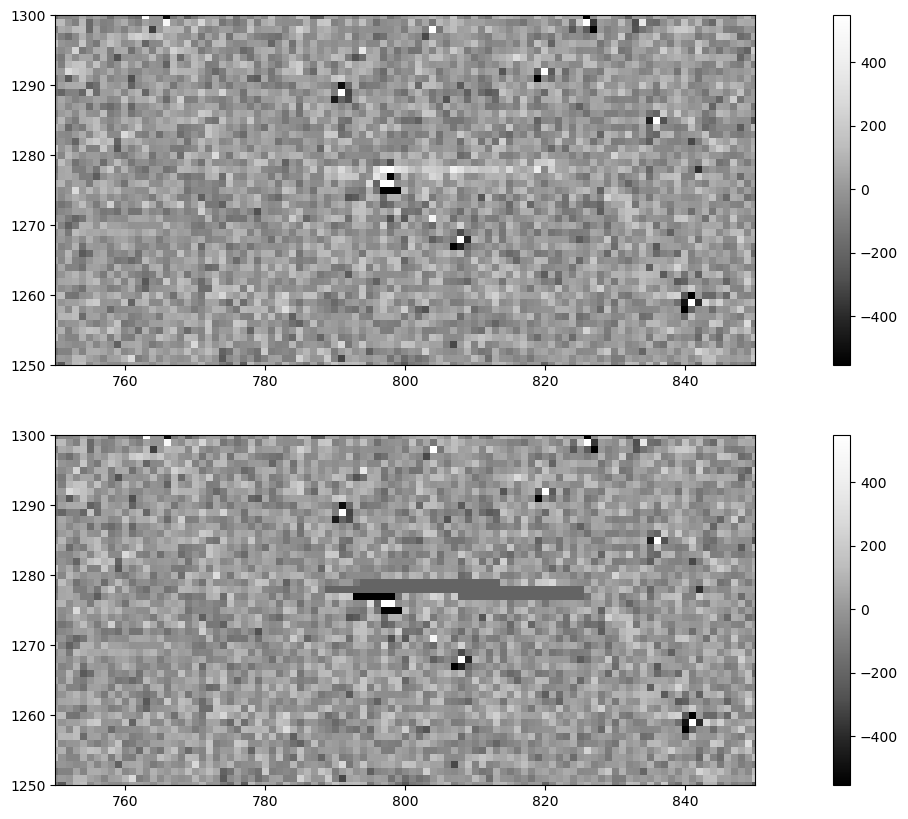

In [269]:
%matplotlib inline
#from ipywidgets import *

sub0 = sub.copy()
#sub0[np.where(mask>0)[0], np.where(mask>0)[1]] = -700
fig, ax = plt.subplots(2,1,figsize=(20,10))
im = ax[0].imshow(sub0,origin='lower',vmin=min_value,vmax=max_value,cmap='Greys_r')
#ax[0].plot(cc,rr,lw=0.75,c='r')
plt.colorbar(im,ax=ax[0])
sub_new = sub.copy()
sub_new[np.where(binary_erosion(mask)>0)[0], np.where(binary_erosion(mask)>0)[1]] = -700
sub_new[np.where(mask_MASTER>0)[0], np.where(mask_MASTER>0)[1]]=-200

im2=ax[1].imshow(sub_new,origin='lower',vmin=min_value,vmax=max_value,cmap='Greys_r')
#ax[1].plot(cc,rr,lw=0.75,c='r')
plt.colorbar(im2,ax=ax[1])

for i in range(2):
    ax[i].set_xlim(750,850)
    ax[i].set_ylim(1250,1300)
plt.show()

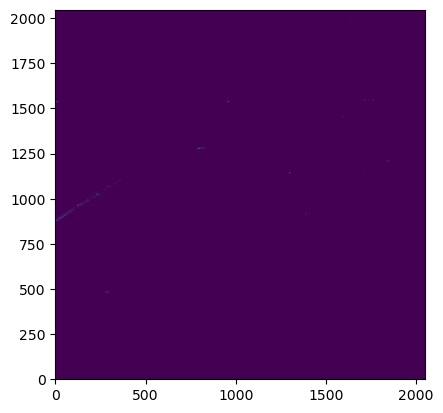

In [262]:
mask2 = mask.copy()
mask2[np.where(mask_MASTER>0)[0], np.where(mask_MASTER>0)[1]]=0
plt.imshow(mask2, origin='lower')
plt.show()


In [ ]:
%matplotlib notebook
lines = phl(mask2, threshold=20, line_length=20, line_gap=10)
df, slopes, bs = get_line_data(lines)
dindex, NUMLINES = collect_segments(df, PLOT=False)
df['linenum'] = dindex

In [ ]:
%matplotlib inline
mask_DEL = np.zeros((2048,2048))
for i in range(len(np.unique(df.linenum.values))):
    LINENUM = np.unique(df.linenum.values)[i]
    print(LINENUM)
    RR, CC, LENGTH = total_line_coords(df, LINENUM=LINENUM, PLOT=False)
    print('Length: ', LENGTH)
    plot_amplitude(RR, CC, sub);
    plt.figure()
    rr, cc, R0, C0, coefficients = fit_coords(RR, CC, LENGTH, sub, PLOT=True)
    GAPS, NGAPS = find_gaps(rr, cc, RR, CC, R0, C0, w=50)
    dat, rollmean, rollstd = rolling_mean(rr, cc, R0, C0, sub)
    df, LBOUNDS, RBOUNDS = find_bounds(df, LINENUM, LENGTH, dat, rollmean, rollstd, GAPS, NGAPS, sub, NSIG=3, PLOT=True)
    mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
                                                              C0, NSIG=3, NHALF=1, NCLOSE=10, PLOT=False)
    mask_MASTER += mask_new
    mask_fit, mask_new, rr_new, cc_new, halfwidth = fit_width(dat, LBOUNDS[0], RBOUNDS[0], rr, cc, R0, 
                                                              C0, NSIG=3, NHALF=2, NCLOSE=10, PLOT=False)
    mask_DEL += mask_new
    print('\n')

In [ ]:
from scipy.optimize import curve_fit, minimize

def tophat(x, baseline, hatmid, hatwidth, height):
    y = np.ones(len(x)) * baseline
    y[(x>=hatmid-hatwidth/2)&(x<=hatmid+hatwidth/2)] = baseline + height
    return y

def objective(params, x, y):
    return np.sum(np.abs(tophat(x, *params) - y))

guess = [0,np.median(CC),CC.max()-CC.min(),
         np.mean(sub[RR,CC])]
print(guess)
res = minimize(objective, guess, args=(dat.c, rollmean), method='Nelder-Mead')
print(res.x)
baseline, hatmid, hatwidth, height = res.x

fig, ax = plt.subplots(1,2)
ax[0].imshow(sub,origin='lower',
             vmin=min_value,
             vmax=max_value,
             cmap='Greys_r')
#ax[0].plot(CCpx,RRpx)
ax[0].set_xlim(0,2048)
#ax[0].set_ylim(500,1500)

ax[0].axvline(leftC,lw=1,c='b')
ax[0].axvline(rightC,lw=1,c='b')
ax[0].axvline(hatmid-hatwidth/2,lw=0.5,c='r')
ax[0].axvline(hatmid+hatwidth/2,lw=0.5,c='r')

ax[1].plot(dat.c,rollmean)
xfit = np.linspace(0,2048,100)
ax[1].plot(xfit, tophat(xfit, *(res.x)))


In [ ]:
plt.scatter(CC,RR,s=1)
plt.axvline(leftC,c='g')
plt.axvline(rightC,c='b')
plt.axhline(leftR,c='g')
plt.axhline(rightR,c='b')
plt.axvline(lchat, c='r')
plt.axvline(rchat, c='r')
plt.axhline(lrhat, c='r')
plt.axhline(rrhat, c='r')

Step 1: determine if there are gaps

If No: Find farthest endpoints. Moving left and right from the place of maximum amplitude, define the x-values where amplitude drops below e.g. 3 sigma for the first time as the two end points.

If Yes: Use subsequent image to determine if it is multiple objects (or could try doing sat_id first, seeing if N_line = N_object, and then if inconclusive then move on to subsequent image since it's a little less reliable?). If it is, split up at the gaps and go back to "if no" for each segment separately. If it is not, merge the line segments into one line by using the overall line fit, and return to "if no" for the meta-line. 

use subsequent image to check for chain of GEO sats 
length of trail / exposure time gives speed, JD time of next image gives you estimate of starting position at next exposure

make local std of rolling mean rather than global and have like falling 

In [ ]:
mask_eroded = binary_erosion(mask_hough)
rr_erode, cc_erode = np.where(mask_eroded>0)[0], np.where(mask_eroded>0)[1]
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(mask_hough,origin='lower')
ax[1].imshow(mask_eroded,origin='lower')

In [ ]:
L = np.arange(35,3000,1)
D = 1e5 # 0.5
R = L**2 /(8*D)
plt.plot(L,R)
plt.yscale('log')
plt.axhline(10)
plt.axvline(500)